In [1]:
import ee

from statgis.gee import landsat_functions, time_series_analysis, zonal_statistics, utils
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks')
sns.set_context('paper')

ee.Initialize()

In [2]:
cities_path = "projects/ee-srnarvaez/assets/municipios_colombia_100k"

cities = ee.FeatureCollection(cities_path)
cities.size().getInfo()

1122

In [3]:
atlantico = cities.filter(ee.Filter.eq("Depto", "Atlántico"))
atlantico_cities = [city["properties"]["MpNombre"] for city in atlantico.getInfo()["features"]]

atlantico_cities

['Santa Lucía',
 'Luruaco',
 'Ponedera',
 'Malambo',
 'Puerto Colombia',
 'Suan',
 'Campo De La Cruz',
 'Manatí',
 'Candelaria',
 'Repelón',
 'Sabanalarga',
 'Palmar De Varela',
 'Santo Tomás',
 'Usiacurí',
 'Polonuevo',
 'Piojó',
 'Sabanagrande',
 'Baranoa',
 'Juan De Acosta',
 'Soledad',
 'Galapa',
 'Tubará',
 'Barranquilla']

In [4]:
atlantico_cities_geoms = {
    city: atlantico.filter(ee.Filter.eq("MpNombre", city)).first().geometry()
    for city in atlantico_cities
}

In [5]:
atlantico_cities_data = {}
for city in atlantico_cities:
    geom = atlantico_cities_geoms[city]

    landsat_collection = ee.ImageCollection([])
    for code in ["LT05", "LE07", "LC08", "LC09"]:
        landsat_collection = landsat_collection.merge(
            ee.ImageCollection(f"LANDSAT/{code}/C02/T1_L2")
            .filterBounds(geom)
            .filterDate("1985-01-01", "2022-12-31")
            .map(landsat_functions.scaler)
            .map(landsat_functions.cloud_mask)
            .map(landsat_functions.rename_bands)
            .map(lambda img: img.select(["BLUE", "GREEN", "RED", "NIR", "SWIR1", "SWIR2", "TEMPERATURE"]))
            .map(lambda img: img.addBands(img.normalizedDifference(["NIR", "RED"]).rename("NDVI")))
        )
    
    chirps_collection = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").filterDate("1985-01-01", "2022-12-31")

    precipitation = time_series_analysis.resample(chirps_collection, ee.Reducer.sum(), "annual")
    ndvi = (
        time_series_analysis.resample(landsat_collection, ee.Reducer.median(), "annual")
        .map(lambda img: utils.calculate_band_number(img))
        .filter(ee.Filter.gt("bands", 0))
    )

    precipitation_data = zonal_statistics.zonal_statistics_collection(precipitation, geom, 5000, "precipitation", ee.Reducer.mean())
    ndvi_data = zonal_statistics.zonal_statistics_collection(ndvi, geom, 5000, ["NDVI", "TEMPERATURE"], ee.Reducer.mean())

    dataframe = precipitation_data.merge(ndvi_data, on="date", how="left")[["date", "precipitation", "TEMPERATURE", "NDVI"]]
    dataframe["city"] = city
    
    atlantico_cities_data[city] = dataframe

In [6]:
dataframe = pd.concat(atlantico_cities_data.values(), ignore_index=True, sort=False).reset_index(drop=True)
dataframe["TEMPERATURE"] = dataframe["TEMPERATURE"] - 273.15
dataframe = dataframe.rename({
    "date": "Time [Y]", "precipitation": "Precipitation [mm]", "TEMPERATURE": "Temperature [°C]", "city": "City" 
}, axis=1)
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874 entries, 0 to 873
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Time [Y]            874 non-null    datetime64[ns]
 1   Precipitation [mm]  874 non-null    float64       
 2   Temperature [°C]    759 non-null    float64       
 3   NDVI                759 non-null    float64       
 4   City                874 non-null    object        
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 34.3+ KB


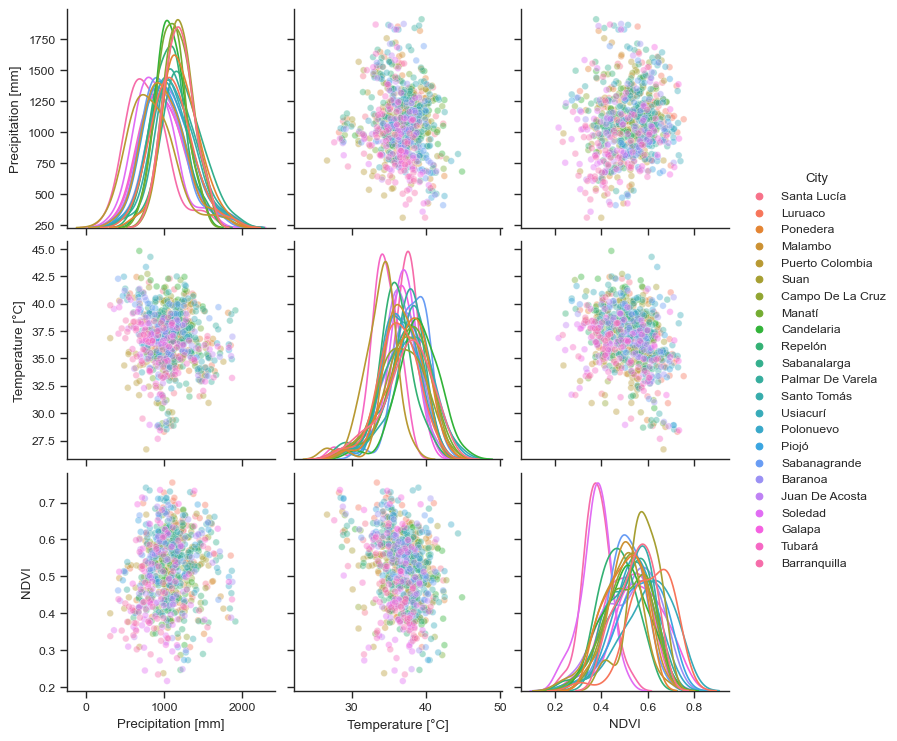

In [7]:
sns.pairplot(data=dataframe, hue="City", plot_kws={"alpha": 0.4}, diag_kws={"fill": False})
plt.show()

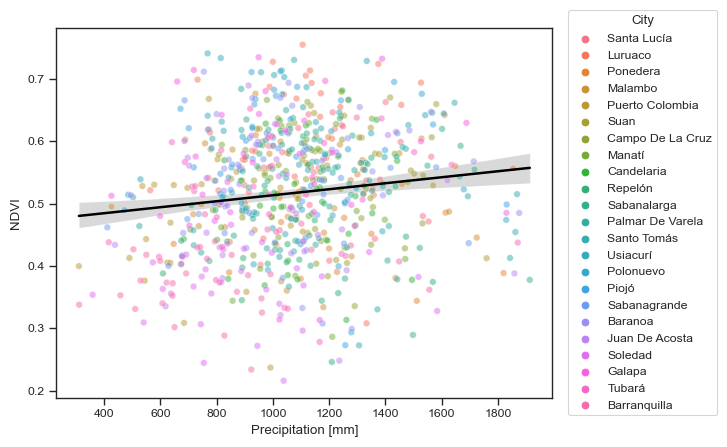

In [8]:
fig, ax = plt.subplots(1)
sns.regplot(data=dataframe, x="Precipitation [mm]", y="NDVI", color="black", scatter=False, ax=ax)
sns.scatterplot(data=dataframe, x="Precipitation [mm]", y="NDVI", hue="City", alpha=0.5, ax=ax)
plt.legend(title="City", bbox_to_anchor=(1.02, 0.5), loc="center left")
plt.show()

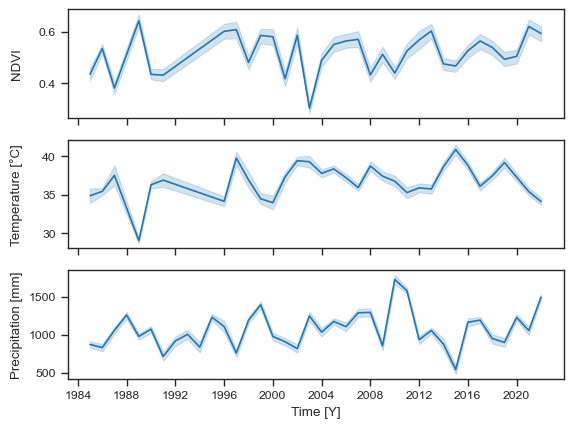

In [9]:
fig, axs = plt.subplots(3, 1, sharex=True)
sns.lineplot(data=dataframe, x="Time [Y]", y="NDVI", ax=axs[0])
sns.lineplot(data=dataframe, x="Time [Y]", y="Temperature [°C]", ax=axs[1])
sns.lineplot(data=dataframe, x="Time [Y]", y="Precipitation [mm]", ax=axs[2])
fig.align_labels()
plt.show()